In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn import datasets, neighbors, linear_model, preprocessing
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv("train.csv")
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [13]:
data.shape[1]

59

Let's try to separate the categorical, binary and continuous/ordinal variables. To get a sense of the continuous and ordinal variables, lets just count the number of entries for each col. If the number of entries is >30 (chosen after first looking at all the values) or so, it is likely a continuous variable, otherwise it is an ordinal variable. 

In [43]:
cols = data.drop("target", axis = 1).columns
bin_cols = []
cat_cols = []
cont_cols = []
ord_cols = []
for i in range(0,len(cols)):
    if "bin" in cols[i]:
        bin_cols.append(cols[i])
    elif "cat" in cols[i]:
        cat_cols.append(cols[i])
    elif len(data[cols[i]].unique()) < 30:
        ord_cols.append(cols[i])
    else:
        cont_cols.append(cols[i])
print(len(bin_cols))
print(len(cat_cols))
print(len(ord_cols))
print(len(cont_cols))

17
14
22
5


For each of the categorical and ordinal variables, what are the category values? 

In [44]:
i=0
for col in (cat_cols+ord_cols):
    print(str(col) + " : " + str(np.sort(data[col].unique())))
    i=i+1
print(i)

ps_ind_02_cat : [-1  1  2  3  4]
ps_ind_04_cat : [-1  0  1]
ps_ind_05_cat : [-1  0  1  2  3  4  5  6]
ps_car_01_cat : [-1  0  1  2  3  4  5  6  7  8  9 10 11]
ps_car_02_cat : [-1  0  1]
ps_car_03_cat : [-1  0  1]
ps_car_04_cat : [0 1 2 3 4 5 6 7 8 9]
ps_car_05_cat : [-1  0  1]
ps_car_06_cat : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
ps_car_07_cat : [-1  0  1]
ps_car_08_cat : [0 1]
ps_car_09_cat : [-1  0  1  2  3  4]
ps_car_10_cat : [0 1 2]
ps_car_11_cat : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
ps_ind_01 : [0 1 2 3 4 5 6 7]
ps_ind_03 : [ 0  1  2  3  4  5  6  7  8  9 10 11]
ps_ind_14 : [0 1 2 3 4

All the binary variables have a value of 0 or 1 as expected (below)

In [45]:
for col in bin_cols:
    print(str(col) + " : " + str(np.sort(data[col].unique())))

ps_ind_06_bin : [0 1]
ps_ind_07_bin : [0 1]
ps_ind_08_bin : [0 1]
ps_ind_09_bin : [0 1]
ps_ind_10_bin : [0 1]
ps_ind_11_bin : [0 1]
ps_ind_12_bin : [0 1]
ps_ind_13_bin : [0 1]
ps_ind_16_bin : [0 1]
ps_ind_17_bin : [0 1]
ps_ind_18_bin : [0 1]
ps_calc_15_bin : [0 1]
ps_calc_16_bin : [0 1]
ps_calc_17_bin : [0 1]
ps_calc_18_bin : [0 1]
ps_calc_19_bin : [0 1]
ps_calc_20_bin : [0 1]


In [48]:
for col in cont_cols:
    print(str(col) + " : " + str(len(data[col].unique())))

id : 595212
ps_reg_03 : 5013
ps_car_12 : 184
ps_car_13 : 70482
ps_car_14 : 850


In [47]:
for col in cont_cols:
    print(str(col) + " : " + str(len(data[col].unique())))

id : 595212
ps_reg_03 : 5013
ps_car_12 : 184
ps_car_13 : 70482
ps_car_14 : 850


In [50]:
data["target"].mean()

0.036447517859182946

The dataset description said that a value of -1 means missing value. Interestingly, the avg. target value for each of choices for each of the categorical values is less than 0.1 except when the value = -1!
Seems like the people with missing info on the following variables are most likely to claim their insurance.
- ps_ind_02_cat
- ps_ind_04_cat
- ps_car_01_cat

However after looking at the frequency distribution of each variable, it looks like the high values of target for missing values is an artifact of the fact that very few entries are missing. Less data => more variability.  

Also some variables that we identified as ordinal have recognizable probability distributions. For example normal, exponential and uniform distributions. 
ps_calc_14

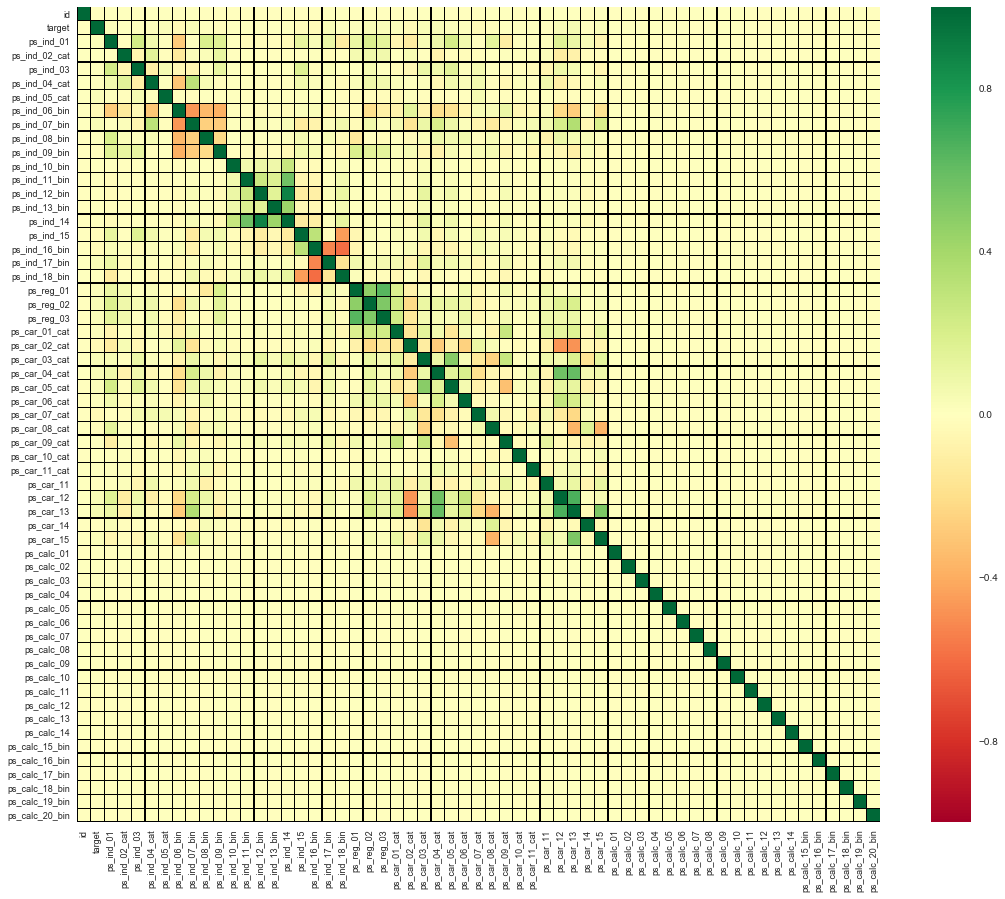

In [58]:
sns.heatmap(data.corr(),cmap='RdYlGn',linewidths=0.2, linecolor = 'k')
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

Some variables are mutually correlated. However no single variable has a strong correlation with 'target'. Lets visualize target on a finer scale of correlation to find the 'most correlated' columns. 

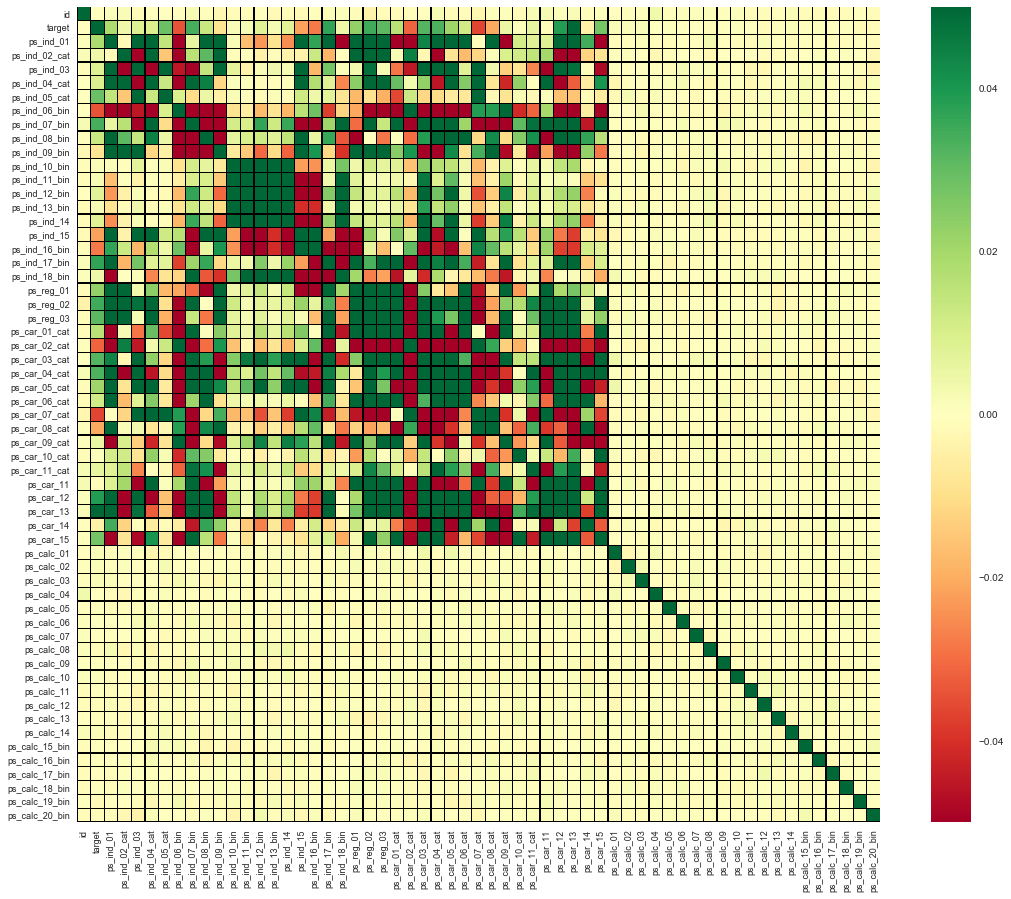

In [62]:
sns.heatmap(data.corr(),cmap='RdYlGn',linewidths=0.2, linecolor = 'k', vmin = -0.05, vmax = 0.05)
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

At this very fine correlation scale, we see some variables have some correlation with the target. Most striking observation is that none of the 'calc' variables is important! Maybe at some point we can throw all of these out to reduce dimensionality. 

# Classification

- Data normalization
- data split into train and cv set

Code for gini (evaluation per the problem description). 
- For the best accuracy, we want a normalized gini score to be as close as possible to 1. 
- The gini score for a random classifier is 0. 
- Also, if we get a negative gini score, we can just reverse the outcome to get a positive gini score of the same magnitude. 
- Gini score is a good metric for a skewed dataset such as this one. 
- For the evaluation, it needs the 'probability' from the classifier, not just the prediction (0 or 1)! 

In [75]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

Let's normalize the data using scikitlearn preprocessing. Each column will have a mean of 0 and variance of 1. 
The output of normalizing is a numpy array, so we convert it back into a pandas dataframe. Note that we will not be normalizing 'y' values. 


In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_np = scaler.fit_transform(data.drop("target", axis=1))
print(X_np.shape)
normalized_data = pd.DataFrame(data=X_np, columns=data.drop("target", axis=1).columns)
normalized_data = pd.concat([normalized_data, data["target"]], axis=1)
normalized_data.describe()

(595212L, 58L)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
count,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,...,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,595212.000000
mean,5.189472e-16,5.665373e-16,1.166160e-15,1.964725e-15,-4.483140e-15,7.187288e-16,2.062436e-15,1.483968e-14,1.419165e-15,-1.496248e-15,...,-1.130574e-15,-8.993241e-18,-2.068966e-15,1.016694e-15,1.245145e-15,3.354911e-15,4.747812e-15,-8.254181e-16,1.230697e-15,0.036448
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.187401
min,-1.732308e+00,-9.579546e-01,-3.549452e+00,-1.638327e+00,-2.872011e+00,-1.040386e+00,-8.058926e-01,-5.881789e-01,-4.427864e-01,-4.769185e-01,...,-1.198640e+00,-1.694679e+00,-2.744809e+00,-3.735054e-01,-1.298852e+00,-1.114930e+00,-6.347299e-01,-7.322253e-01,-4.255369e-01,0.000000
25%,-8.659530e-01,-9.579546e-01,-5.400936e-01,-8.975586e-01,-8.448917e-01,-2.999971e-01,-8.058926e-01,-5.881789e-01,-4.427864e-01,-4.769185e-01,...,-3.673585e-01,-5.146587e-01,-5.603287e-01,-3.735054e-01,-1.298852e+00,-1.114930e+00,-6.347299e-01,-7.322253e-01,-4.255369e-01,0.000000
50%,-5.963620e-04,-4.538684e-01,-5.400936e-01,-1.567903e-01,-8.448917e-01,-2.999971e-01,-8.058926e-01,-5.881789e-01,-4.427864e-01,-4.769185e-01,...,-3.673585e-01,7.535169e-02,-1.962487e-01,-3.735054e-01,7.699104e-01,8.969170e-01,-6.347299e-01,-7.322253e-01,-4.255369e-01,0.000000
75%,8.657973e-01,5.543042e-01,9.645855e-01,5.839780e-01,1.182227e+00,-2.999971e-01,1.240860e+00,1.700163e+00,-4.427864e-01,-4.769185e-01,...,4.639233e-01,6.653621e-01,5.319112e-01,-3.735054e-01,7.699104e-01,8.969170e-01,1.575473e+00,1.365700e+00,-4.255369e-01,0.000000
max,1.733302e+00,2.570649e+00,3.973944e+00,2.435899e+00,1.182227e+00,4.142338e+00,1.240860e+00,1.700163e+00,2.258425e+00,2.096794e+00,...,7.114178e+00,5.975455e+00,5.629031e+00,2.677337e+00,7.699104e-01,8.969170e-01,1.575473e+00,1.365700e+00,2.349973e+00,1.000000


In [92]:
train,cv=train_test_split(normalized_data,test_size = 0.1, random_state=0,stratify=normalized_data['target'])
train.describe()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
count,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,...,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000,535690.000000
mean,0.000359,0.000309,0.000149,-0.000197,0.000062,0.000406,0.000276,-0.000461,0.000529,-0.000333,...,0.000386,-0.000441,-0.000416,-0.000421,0.000627,-0.000552,0.000192,-0.000393,-0.000079,0.036448
std,1.000478,1.000135,1.000526,0.999514,1.000006,1.000799,1.000061,0.999745,1.000481,0.999731,...,1.000420,0.999760,0.999667,0.999516,0.999835,1.000061,1.000091,0.999876,0.999925,0.187403
min,-1.732308,-0.957955,-3.549452,-1.638327,-2.872011,-1.040386,-0.805893,-0.588179,-0.442786,-0.476919,...,-1.198640,-1.694679,-2.744809,-0.373505,-1.298852,-1.114930,-0.634730,-0.732225,-0.425537,0.000000
25%,-0.866053,-0.957955,-0.540094,-0.897559,-0.844892,-0.299997,-0.805893,-0.588179,-0.442786,-0.476919,...,-0.367359,-0.514659,-0.560329,-0.373505,-1.298852,-1.114930,-0.634730,-0.732225,-0.425537,0.000000
50%,-0.000273,-0.453868,-0.540094,-0.156790,-0.844892,-0.299997,-0.805893,-0.588179,-0.442786,-0.476919,...,-0.367359,0.075352,-0.196249,-0.373505,0.769910,0.896917,-0.634730,-0.732225,-0.425537,0.000000
75%,0.866825,0.554304,0.964585,0.583978,1.182227,-0.299997,1.240860,1.700163,-0.442786,-0.476919,...,0.463923,0.665362,0.531911,-0.373505,0.769910,0.896917,1.575473,1.365700,-0.425537,0.000000
max,1.733302,2.570649,3.973944,2.435899,1.182227,4.142338,1.240860,1.700163,2.258425,2.096794,...,7.114178,5.975455,5.629031,2.677337,0.769910,0.896917,1.575473,1.365700,2.349973,1.000000


In [71]:
X_train = train.drop("target", axis=1)
y_train = train["target"]
X_cv = test.drop("target", axis = 1)
y_cv = test["target"]
estimator = LogisticRegression(C=1, class_weight = "balanced")
fit = estimator.fit(X_train, y_train)

In [98]:
from sklearn.metrics import classification_report
score = fit.score(X_cv, y_cv)
print(score)
print(classification_report(y_cv, estimator.predict(X_cv)))
gini_cv = gini_normalized(y_cv, estimator.predict_proba(X_cv)[:,1])
gini_train = gini_normalized(y_train, estimator.predict_proba(X_train)[:,1])
print([gini_train, gini_cv])

0.623903766675
             precision    recall  f1-score   support

        0.0       0.97      0.63      0.76     57353
        1.0       0.05      0.53      0.09      2169

avg / total       0.94      0.62      0.74     59522

[0.2524553383726405, 0.22576866726141573]


In [96]:
estimator.predict_proba(X_cv)[:, 0]

array([ 0.51427334,  0.67648521,  0.52766208, ...,  0.59406421,
        0.30425292,  0.6757102 ])

In [101]:
estimator2 = LogisticRegression(C=.01, class_weight = "balanced")
fit = estimator2.fit(X_train, y_train)

In [100]:
score = fit.score(X_cv, y_cv)
print(score)
print(classification_report(y_cv, estimator2.predict(X_cv)))
gini_cv = gini_normalized(y_cv, estimator2.predict_proba(X_cv)[:,1])
gini_train = gini_normalized(y_train, estimator2.predict_proba(X_train)[:,1])
print([gini_train, gini_cv])

0.624844595276
             precision    recall  f1-score   support

        0.0       0.97      0.63      0.76     57353
        1.0       0.05      0.53      0.09      2169

avg / total       0.94      0.62      0.74     59522

[0.25145641274199249, 0.22547139717111242]
